## Train a Segmentation Model

This notebook trains a segmentation model on some Sentinel-2 data using crop labels from Radiant Earth's [South Africa Crop Type Competition](http://registry.mlhub.earth/10.34911/rdnt.j0co8q/).

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import datetime
import rioxarray
import pystac_client
import planetary_computer
import stackstac
import torch
import requests
import torch.utils.data
import functools
import rasterio.plot
import numpy as np
import dask

import warnings
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

I made a STAC catalog for the label data.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/train/collection.json"
)

In [3]:
from dask.distributed import Client

client = Client(processes=False)

In [4]:
N_SCENES = 100
links = training_catalog.get_item_links()[:N_SCENES]

@dask.delayed
def get_label_item(link):
    link.resolve_stac_object()
    return link.target

links = [get_label_item(link) for link in links]
%time label_items = dask.compute(*links)

CPU times: user 1.93 s, sys: 142 ms, total: 2.07 s
Wall time: 2.29 s


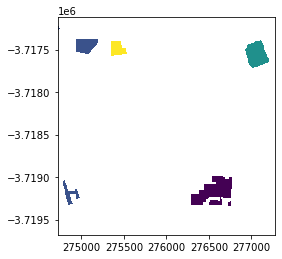

In [8]:
label_item = next(training_catalog.get_all_items())

rasterio.plot.show(
    rasterio.open(label_item.assets["labels"].get_absolute_href())
);

They have links to the meaning of the class labels

In [9]:
labels = requests.get(label_item.assets['raster_values'].get_absolute_href()).json()
labels

{'0': 'No Data',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures (perennial)',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

## Dataset / Dataloader

We'll write a helper to load

* the labels
* a corresponding scene from sentinel, cropped and transformed to the same area and CRS as the labels

Thanks to Caleb Robinson from Microsoft's AI for Good team for help on the loader.

In [10]:
from ipyleaflet import Map, GeoJSON

data = {
    "type": "FeatureCollection",
    "features": [],
}
for label_item in label_items:
    data["features"].append(label_item.geometry)

    
center = shapely.geometry.shape(
    label_item.geometry
).centroid.bounds[:2][::-1]

m = Map(center=center, zoom=7)
layer = GeoJSON(data=data)

m.add_layer(layer)
m

Map(center=[-31.84927089165829, 18.524483640889127], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Let's do one big search for sentinel scenes, rather than many small ones...

In [11]:
# find the convex hull
import shapely.ops

shapes = [shapely.geometry.shape(label_item.geometry) for label_item in label_items]
union = shapely.ops.cascaded_union(shapes)
shape = union.convex_hull
bbox = shape.bounds

In [12]:
# all the labels are from the same datetime
len(set([label_item.datetime for label_item in label_items]))

1

In [13]:
%%time
stac = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)

month = datetime.timedelta(days=31)
label_date = label_items[0].datetime
date_range = f"{label_date - month:%Y-%m-%d}/{label_date + month:%Y-%m-%d}"

search = stac.search(collections=["sentinel-2-l2a"], bbox=bbox, limit=500, datetime=date_range)
sentinel_items = list(search.get_all_items())

CPU times: user 483 ms, sys: 16.3 ms, total: 499 ms
Wall time: 2.24 s


In [14]:
def find_match(label_item, sentinel_items):
    label_shape = shapely.geometry.shape(label_item.geometry)
    # make sure we we don't pick a scene that just partially overlaps
    items2 = [
        item
        for item in sentinel_items
        if (shapely.geometry.shape(item.geometry).intersection(label_shape).area / label_shape.area) > 0.9
    ]
    # TODO: what if a label raster spans a sentinel scene?
    sentinel_item = sorted(
        items2,
        key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    )[0]
    return sentinel_item

In [15]:
# @functools.lru_cache(maxsize=None)
def get_item(label_item, sentinel_items, assets):
    assets = list(assets)
    labels = rioxarray.open_rasterio(
        label_item.assets['labels'].get_absolute_href(),
    ).squeeze()

    sentinel_item = find_match(label_item, sentinel_items)
    bounds = tuple(round(x, 0) for x in labels.rio.bounds())

    data = stackstac.stack(
        planetary_computer.sign(sentinel_item).to_dict(),
        assets=assets, dtype="float32", resolution=10,
        bounds=bounds, epsg=labels.rio.crs.to_epsg()
    ).squeeze().compute(scheduler="single-threaded")

    assert data.shape[1:] == labels.shape
    data = data.assign_coords(x=labels.x.data, y=labels.y.data)
    mean, std = data.mean(dim=("y", "x")), data.std(dim=("y", "x"))
    data /= 4000
#     data -= mean
#     data /= std
    data = np.clip(data, 0, 1)
    return data, labels.astype("int64")

Let's try loading them all into memory...

In [16]:
%%time
get_item_ = dask.delayed(get_item, nout=2)
assets = ("B03", "B04", "B05")

Xys = [get_item_(label_item, sentinel_items, assets) for label_item in label_items]

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 42.2 ms


In [17]:
Xys = dask.persist(*Xys)

We'll wrap that up in a small pytorch Dataset class:

In [18]:
class STACDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.as_tensor(X.data) 
        y = torch.as_tensor(y.data)
        return X, y

# class STACDataset(torch.utils.data.Dataset):
#     def __init__(self, label_items, labels, assets):
#         self.label_items = label_items
#         self.labels = labels
#         self.assets = tuple(assets)

#     def __len__(self):
#         return len(self.label_items)

#     @functools.lru_cache(maxsize=None)
#     def __getitem__(self, idx):
#         label_item = self.label_items[idx]
#         X, y = get_item(label_item, assets=self.assets)

#         X = torch.as_tensor(X.data) 
#         y = torch.as_tensor(y.data)

#         return X, y

In [19]:
%%time
Xys = dask.compute(*Xys)

CPU times: user 10.3 s, sys: 704 ms, total: 11 s
Wall time: 21.8 s


In [20]:
dataset = STACDataset(Xys)
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

## Model Definition

In [21]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet18",
    in_channels=len(assets),
    classes=len(labels),
)

# loss = smp.losses.SoftCrossEntropyLoss(smooth_factor=0.1)
loss = smp.utils.losses.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()))
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device="cuda:0",
    verbose=True,
)

## Training

In [22]:
%%time
with torch.cuda.device(0):
    train_epoch.run(loader)

train: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, cross_entropy_loss - 1.982, iou_score - 3.526]
CPU times: user 3.43 s, sys: 4.04 s, total: 7.48 s
Wall time: 2.27 s


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def visualize(X, y):
    with torch.no_grad():
        X2 = (X.reshape((1,) + X.shape)).to("cuda")
        output = model.predict(X2)

    data = np.asarray(X.to("cpu"))[0]  # just the first band
    output = np.asarray(output[0].argmax(0).to("cpu"))

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=True)

    ax1.imshow(data, cmap="gray")

    rasterio.plot.show(np.asarray(y.to("cpu")), ax=ax2)
    rasterio.plot.show(output, ax=ax3);

    return ax1, ax2, ax3

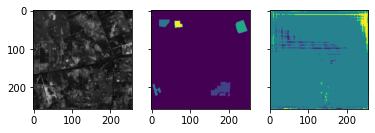

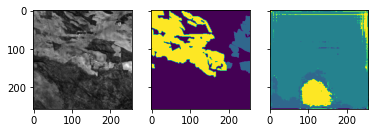

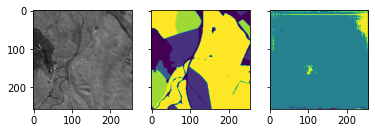

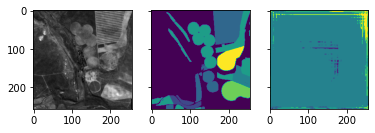

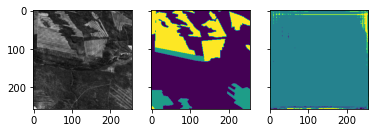

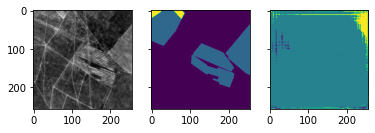

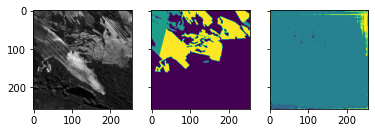

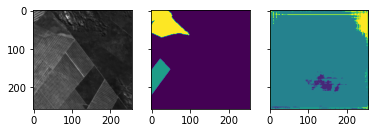

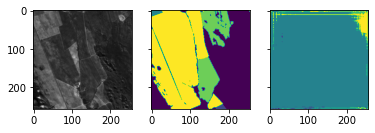

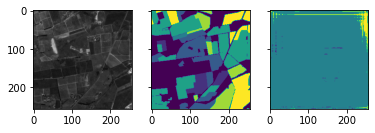

In [24]:
for i in range(10):
    visualize(*dataset[i]);

Train it a bit longer.

In [25]:
%%time
with torch.cuda.device(0):
    for i in range(80):
        train_epoch.run(loader)
        print(i, end="\r\n")

train: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s, cross_entropy_loss - 1.37, iou_score - 0.404] 
0
train: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s, cross_entropy_loss - 1.129, iou_score - 0.9927]
1
train: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, cross_entropy_loss - 1.023, iou_score - 1.125]
2
train: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, cross_entropy_loss - 0.9665, iou_score - 1.28] 
3
train: 100%|██████████| 10/10 [00:01<00:00,  5.59it/s, cross_entropy_loss - 0.9549, iou_score - 1.232]
4
train: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, cross_entropy_loss - 0.9391, iou_score - 1.803]
5
train: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, cross_entropy_loss - 0.9146, iou_score - 1.373]
6
train: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s, cross_entropy_loss - 0.9031, iou_score - 2.32] 
7
train: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s, cross_entropy_loss - 0.898, iou_score - 1.717] 
8
train: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s, cr

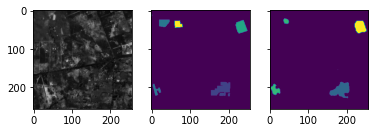

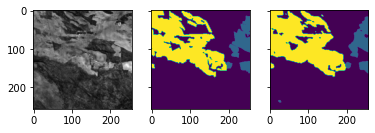

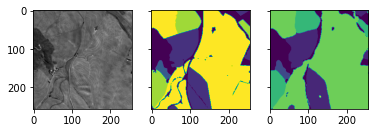

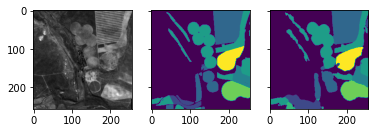

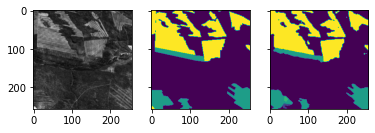

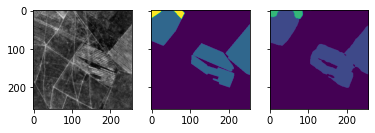

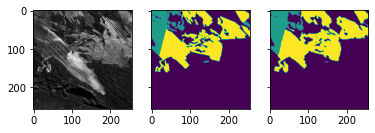

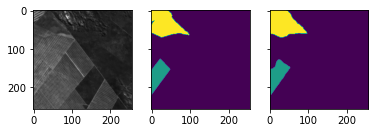

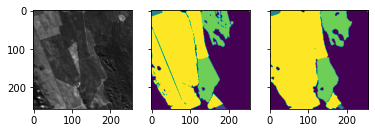

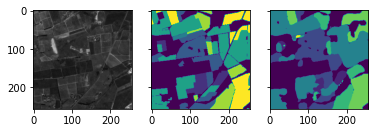

In [26]:
for i in range(10):
    visualize(*dataset[i]);